<a href="https://colab.research.google.com/github/OptimizationExpert/Andrew6rant/blob/main/Final_Gerrymandering_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo

In [34]:
import pandas as pd
!pip install ortools
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt # Data visualization
import random
import numpy as np
import time

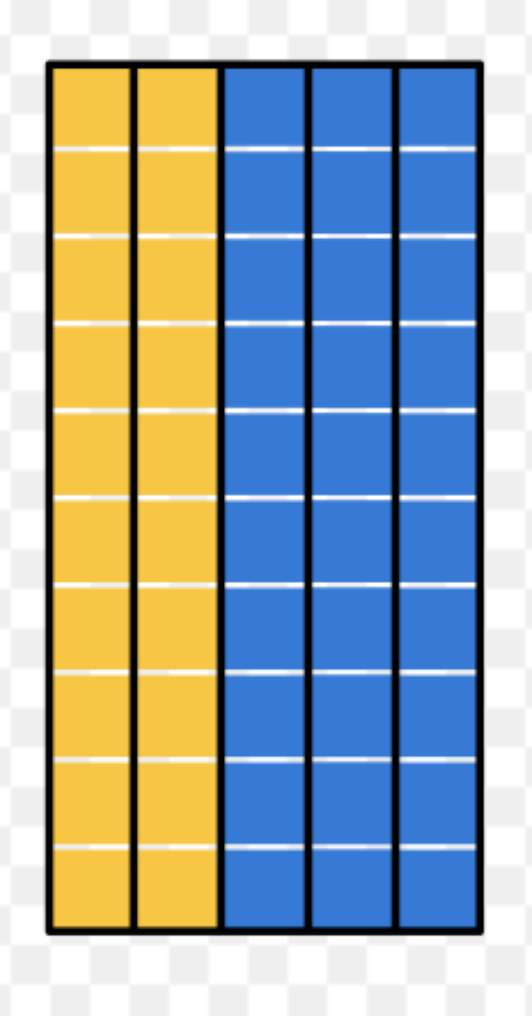

{1: (0, 0, 0),
 2: (1, 0, 0),
 3: (2, 0, 1),
 4: (3, 0, 1),
 5: (4, 0, 1),
 6: (0, 1, 0),
 7: (1, 1, 0),
 8: (2, 1, 1),
 9: (3, 1, 1),
 10: (4, 1, 1),
 11: (0, 2, 0),
 12: (1, 2, 0),
 13: (2, 2, 1),
 14: (3, 2, 1),
 15: (4, 2, 1),
 16: (0, 3, 0),
 17: (1, 3, 0),
 18: (2, 3, 1),
 19: (3, 3, 1),
 20: (4, 3, 1),
 21: (0, 4, 0),
 22: (1, 4, 0),
 23: (2, 4, 1),
 24: (3, 4, 1),
 25: (4, 4, 1),
 26: (0, 5, 0),
 27: (1, 5, 0),
 28: (2, 5, 1),
 29: (3, 5, 1),
 30: (4, 5, 1),
 31: (0, 6, 0),
 32: (1, 6, 0),
 33: (2, 6, 1),
 34: (3, 6, 1),
 35: (4, 6, 1),
 36: (0, 7, 0),
 37: (1, 7, 0),
 38: (2, 7, 1),
 39: (3, 7, 1),
 40: (4, 7, 1),
 41: (0, 8, 0),
 42: (1, 8, 0),
 43: (2, 8, 1),
 44: (3, 8, 1),
 45: (4, 8, 1),
 46: (0, 9, 0),
 47: (1, 9, 0),
 48: (2, 9, 1),
 49: (3, 9, 1),
 50: (4, 9, 1)}

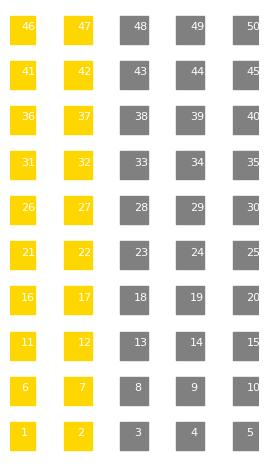

In [35]:
Nr = 10
Nc = 5
KOLOR = ['gold','grey']
data={}
counter =0
plt.figure(figsize=(3,5))
for r in range(Nr):
  for c in range(Nc):
    counter +=1
    if c<=1:
      val=0
    else:
      val = 1
    data[counter] = (c,r,val)
    plt.scatter(c,r,s=400, marker = 's', color = KOLOR[val])
    plt.text(c,r,s=str(counter), fontsize=8, c='w')


plt.tight_layout()
plt.axis('off')
data

In [36]:
def check(n,m,data):
  wi = (data[n][0],data[n][1])
  wj = (data[m][0],data[m][1])
  return n!=m and ((wi[0]== wj[0] and abs(wi[1]-wj[1])==1 ) or (wi[1]== wj[1] and abs(wi[0]-wj[0])==1 ) )



OPTIMAL
0.0 0.0
Time  4.312872648239136
Min of objective function: 0.0

Region 0: 1
Region 1: 0
Region 2: 1
Region 3: 0
Region 4: 1


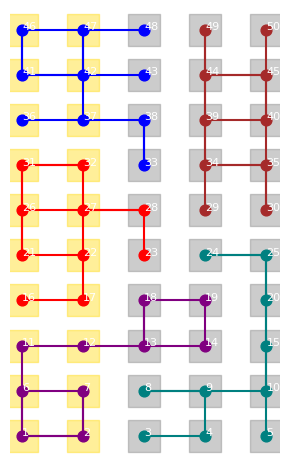

In [38]:

regions = range(5)
nodes = range(1,50+1)
def main() -> None:
    # Creates the model.
    model = cp_model.CpModel()

    assign = {(n,r): model.NewBoolVar(f"assign_{n}_{r}") for n in nodes
              for r in regions}

    source = {(n,r): model.NewBoolVar(f"source_{n}_{r}") for n in nodes
              for r in regions}
    win = {r: model.NewBoolVar( f"win_{r}")
              for r in regions}


    flow = {(i,j,r): model.NewIntVar(0,10,f"flow_{i}_{j}_{r}") for i in nodes
              for j in nodes for r in regions if check(i,j,data)}

    for r in regions:
      expressions = [source[n,r] for n in nodes]
      model.AddExactlyOne(expressions)

      expressions_assign = [assign[n,r] for n in nodes]
      model.Add(sum(expressions_assign) == 10)

      expressions_winD = [assign[n,r] for n in nodes if data[n][2]==0]
      expressions_winR = [assign[n,r] for n in nodes if data[n][2]==1]

      model.Add(sum(expressions_winD) != sum(expressions_winR))

      model.Add(sum(expressions_winD) > sum(expressions_winR)).OnlyEnforceIf(win[r])
      model.Add(sum(expressions_winD) < sum(expressions_winR)).OnlyEnforceIf(win[r].Not())



    for n in nodes:
      expressions_nodal = [source[n,r] for r in regions]
      model.AddAtMostOne(expressions_nodal)

      expressions_assign = [assign[n,r] for r in regions]
      model.Add(sum(expressions_assign) ==1)


    for (n,r) in assign:
      model.Add( 10*source[n,r] - assign[n,r] == sum(flow[n,j,r]-flow[j,n,r] for j in nodes if check(n,j,data) ) )
      model.Add(source[n,r]<= assign[n,r])

    for (i,j,r) in flow:
      model.Add(flow[i,j,r] <= 10*assign[i,r])
      model.Add(flow[i,j,r] <= 10*assign[j,r])

    model.Add(sum(win[r] for r in regions)== 3)

    for n in nodes:
      for m in nodes:
        for r in regions:
           wi = (data[n][0],data[n][1])
           wj = (data[m][0],data[m][1])
           if (wi[0]-wj[0])**2 + (wi[1]-wj[1])**2 > 25:
              model.Add(assign[n,r]+assign[m,r] <= 1)


    solver = cp_model.CpSolver()
    solver.parameters.subsolvers[:] = ['core', 'pseudo_costs', 'no_lp']
    solver.parameters.max_time_in_seconds = 1200
    solver.parameters.num_search_workers = 4
    status = solver.solve(model)
    print(solver.StatusName(status))
    print(solver.ObjectiveValue(), solver.BestObjectiveBound())

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        return solver , source, assign, flow,win

    else:
        print("No solution found.")


if __name__ == "__main__":
  st= time.time()
  solver , source, assign, flow, win = main()
  print("Time ", time.time()-st)
  print(f"Min of objective function: {solver.objective_value}\n")

  counter =0
  plt.figure(figsize=(3.2,5))
  for r in range(Nr):
    for c in range(Nc):
      counter +=1
      if c<=1:
        val=0
      else:
        val = 1
      data[counter] = (c,r,val)
      plt.scatter(c,r,s=500, marker = 's', color = KOLOR[val], alpha = 0.4)
      plt.text(c,r,s=str(counter), fontsize=8, c='w')


  plt.tight_layout()
  plt.axis('off')

  KOLORS = [
      "red", "brown", "blue", "teal", "purple", "cyan", "magenta",
      "yellow", "lime", "pink", "brown", "gray", "olive", "navy", "teal"]
  for r in regions:
    print(f"Region {r}:", solver.value(win[r]))
    for n in nodes:
      if solver.value(assign[n,r]):
        x,y = data[n][0], data[n][1]
        plt.scatter(x,y,s=60, marker = 'o', color = KOLORS[r])
      if solver.value(source[n,r]):
        x,y = data[n][0], data[n][1]
        #plt.scatter(x,y,s=300, marker = 'p', color = KOLOR[r])
        #print(n,r)
  for (i,j,r),v in flow.items():
    if solver.value(v):
      x1,y1 = data[i][0], data[i][1]
      x2,y2 = data[j][0], data[j][1]
      plt.plot([x1,x2],[y1,y2],color = KOLORS[r])







In [40]:
n,m = 25, 3
wi = (data[n][0],data[n][1])
wj = (data[m][0],data[m][1])
if (wi[0]-wj[0])**2 + (wi[1]-wj[1])**2 > 25:
  print("catch")
